# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Table of contents
- [Project Statement](#Project-Statement)
- [Table of contents](#Table-of-contents)
- [0. Initialization](#0.-Initialization)
    * [1. Load Data](#1.-Load-Data)
- [2. EDA](#2.-EDA)
    * [2.1. Number of movies and number of reviews per year](#2.1.-Number-of-movies-and-number-of-reviews-per-year)
    * [2.2. Distribution of number of reviews per movie](#2.2.-Distribution-of-number-of-reviews-per-movie)
    * [2.3. Rating distribution and comparison test/train set](#2.3.-Rating-distribution-and-comparison-test/train-set)
    * [2.4. Positive and negative reviews](#2.4.-Positive-and-negative-reviews)
- [3. Model Building](#3.-Model-Building)
    * [3.1. Evaluation Procedure](#3.1.-Evaluation-Procedure)
    * [3.2 Preprocessing: Normalization](#3.2-Preprocessing:-Normalization)
    * [3.3. Train / Test Split](#3.3.-Train-/-Test-Split)
    * [3.4. Model Training](#3.4.-Model-Training)
        + [3.4.1. Dummy Baseline model](#3.4.1.-Dummy-Baseline-model)
        + [3.4.2. Model 1 - NLTK, TF-IDF and LR](#3.4.2.-Model-1---NLTK,-TF-IDF-and-LR)
            - [3.4.2.1. Basic model](#3.4.2.1.-Basic-model)
            - [3.4.2.2. Grid search](#3.4.2.2.-Grid-search)
        + [3.4.3. Model 2 - spaCy, TF-IDF and LR](#3.4.3.-Model-2---spaCy,-TF-IDF-and-LR)
            - [3.4.3.1. Basic model](#3.4.3.1.-Basic-model)
            - [3.4.3.2. Grid search](#3.4.3.2.-Grid-search)
        + [3.4.4. Model 4 - spaCy, TF-IDF and LGBMClassifier](#3.4.4.-Model-4---spaCy,-TF-IDF-and-LGBMClassifier)
        + [3.4.5. BERT, LR](#3.4.5.-BERT,-LR)
            - [3.4.5.1. Bert embeddings](#3.4.5.1.-Bert-embeddings)
            - [3.4.5.2. Logistic Regression](#3.4.5.2.-Logistic-Regression)
- [4. My Reviews](#4.-My-Reviews)
    * [4.1. Creation and normalization](#4.1.-Creation-and-normalization)
    * [4.2. NLTK tfidf and Logreg](#4.2.-NLTK-tfidf-and-Logreg)
    * [4.4. Spacy tfidf and Logreg](#4.4.-Spacy-tfidf-and-Logreg)
    * [4.5. Spacy tfidf and LGBM](#4.5.-Spacy-tfidf-and-LGBM)
    * [4.6. Bert and LR](#4.6.-Bert-and-LR)
- [5. Conclusion](#5.-Conclusion)

# 0. Initialization

In [1]:
# Activate autocomplete
%config Completer.use_jedi = False

# Constants
RANDOM_STATE = 42

In [2]:
import math
import re 

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics


from tqdm.auto import tqdm

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## 1. Load Data

In [5]:
df_reviews = pd.read_csv('./01_data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
try:
    df_reviews = pd.read_csv('./01_data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    print('test')
    df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    
display(df_reviews.head(5))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
display(df_reviews.info())
display(df_reviews.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

None

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
print('Example review:\n', df_reviews['review'][0], '\n')

# Checking train/test distibution
print('test train split:\n', df_reviews['ds_part'].value_counts(), '\n')

# Checking class balance
print('class balance:\n', df_reviews['pos'].value_counts())

Example review:
 The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie! 

test train split:
 train    23796
test     23535
Name: ds_part, dtype: int64 

class balance:
 0    23715
1    23616
Name: pos, dtype: int64


>**Observations:**
> - Data is already split into test and train set with a ratio around 50:50
> - The target classes are balanced (good/bad reviews), so no preprocessing regarding that topic is needed
> - The text need to be preprocessed (stemming, stop words...)

# 2. EDA
> In this step the EDA has been carried out to check the data for anaomalies.  
> In this process, the test and train data and their individual distribution was checked as well to make sure, that both datasets are balanced and clean

## 2.1. Number of movies and number of reviews per year
> In this chapter the number of movies and reviews is plotted over the years

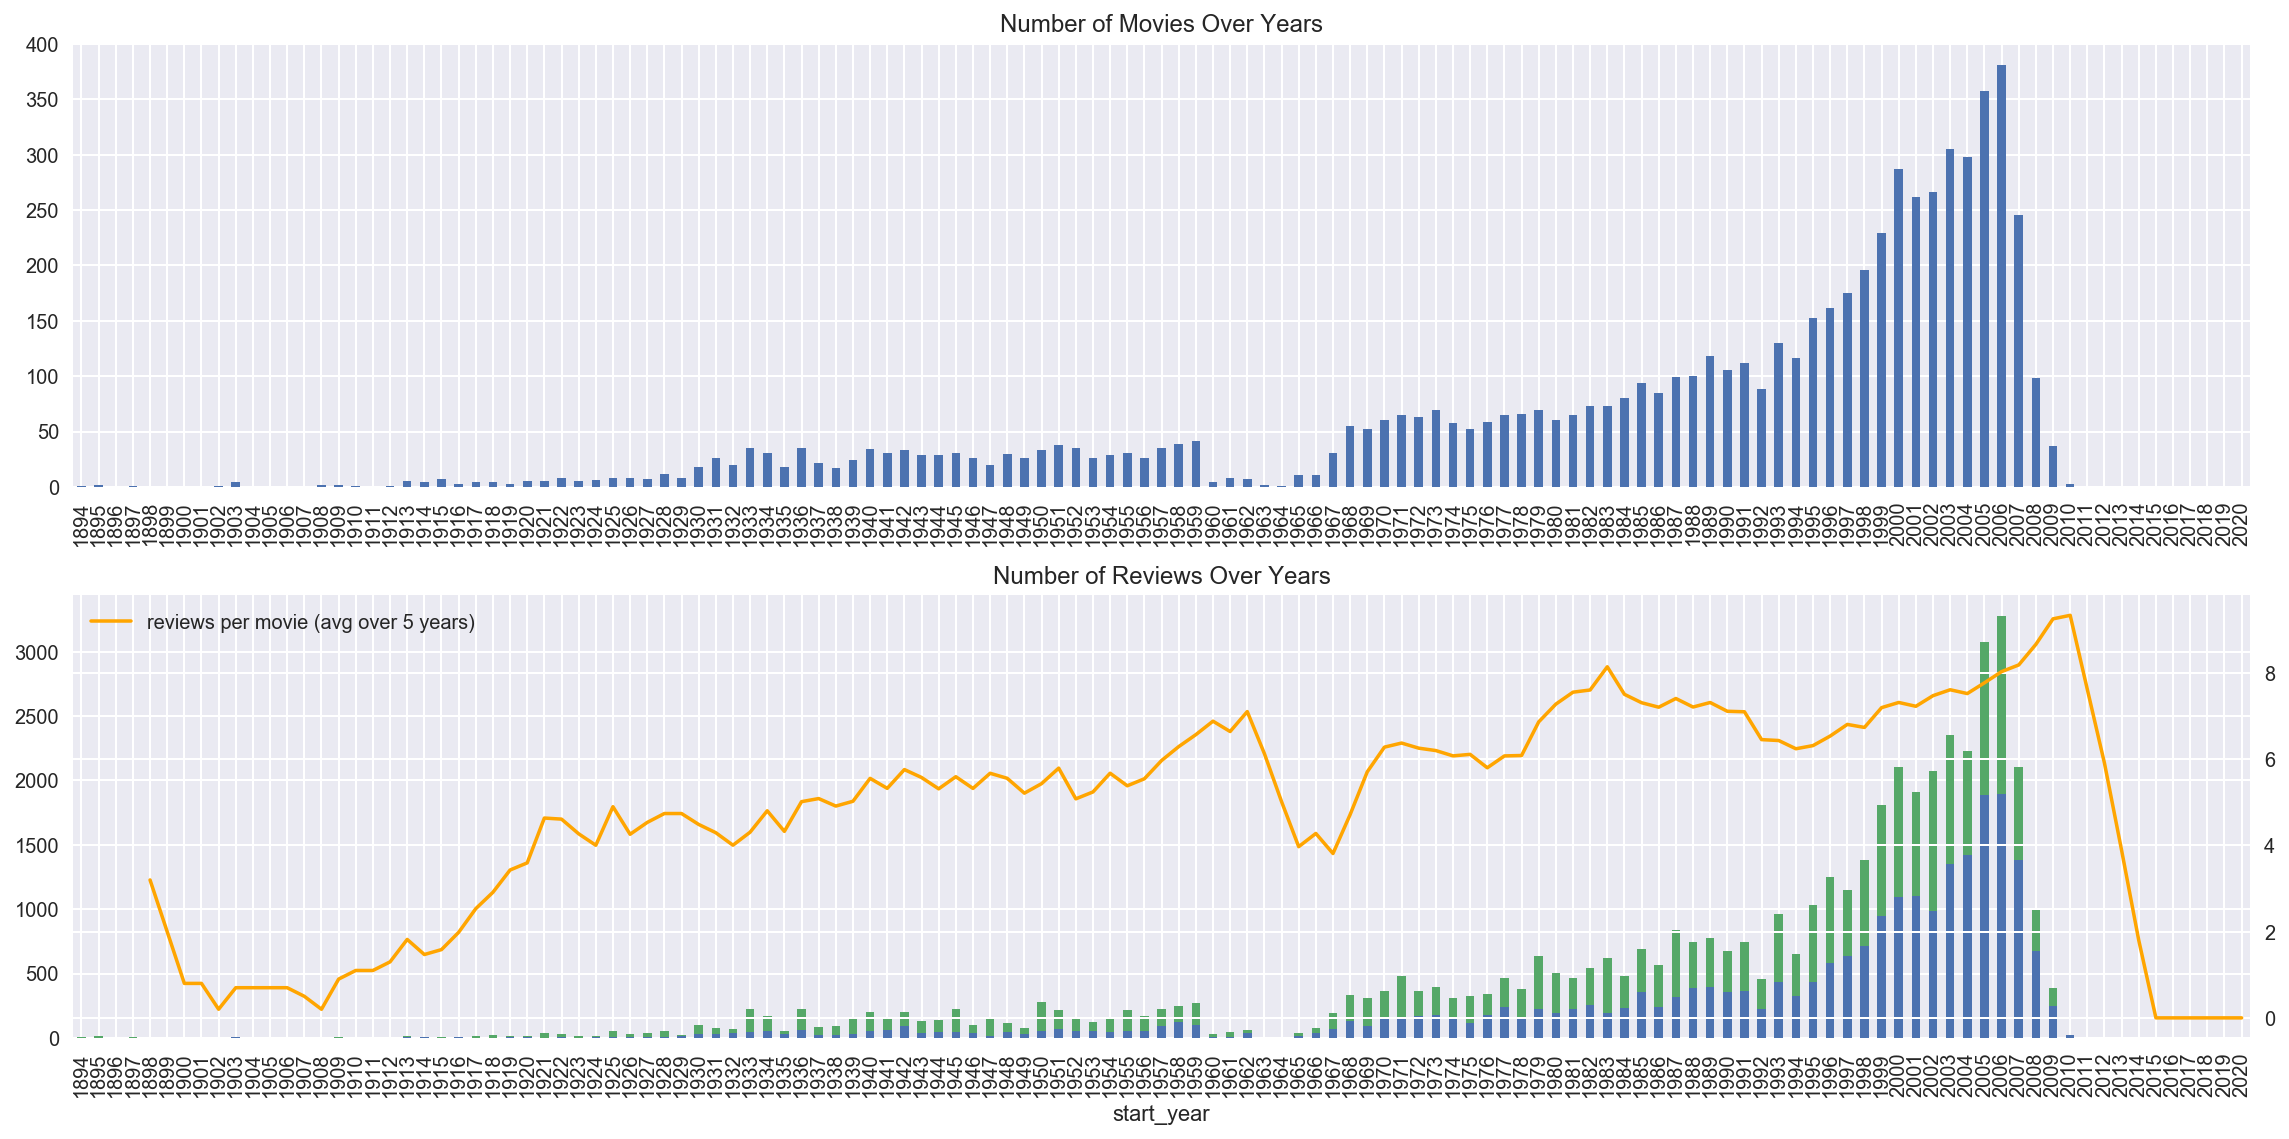

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

> **Observations:**
> - The dataset contains mainly reviews between 1966 and 2009
> - The number of moviews and the number of reviews are corresponding, so does the average
> - There is a lack of interviewes between 1960-1966, the reason is not obvious and data kann not be filled with a propper method due to the nature of the reviews.

## 2.2. Distribution of number of reviews per movie

> In this chapter the distribution of number of reviews per movie with the exact counting and KDE

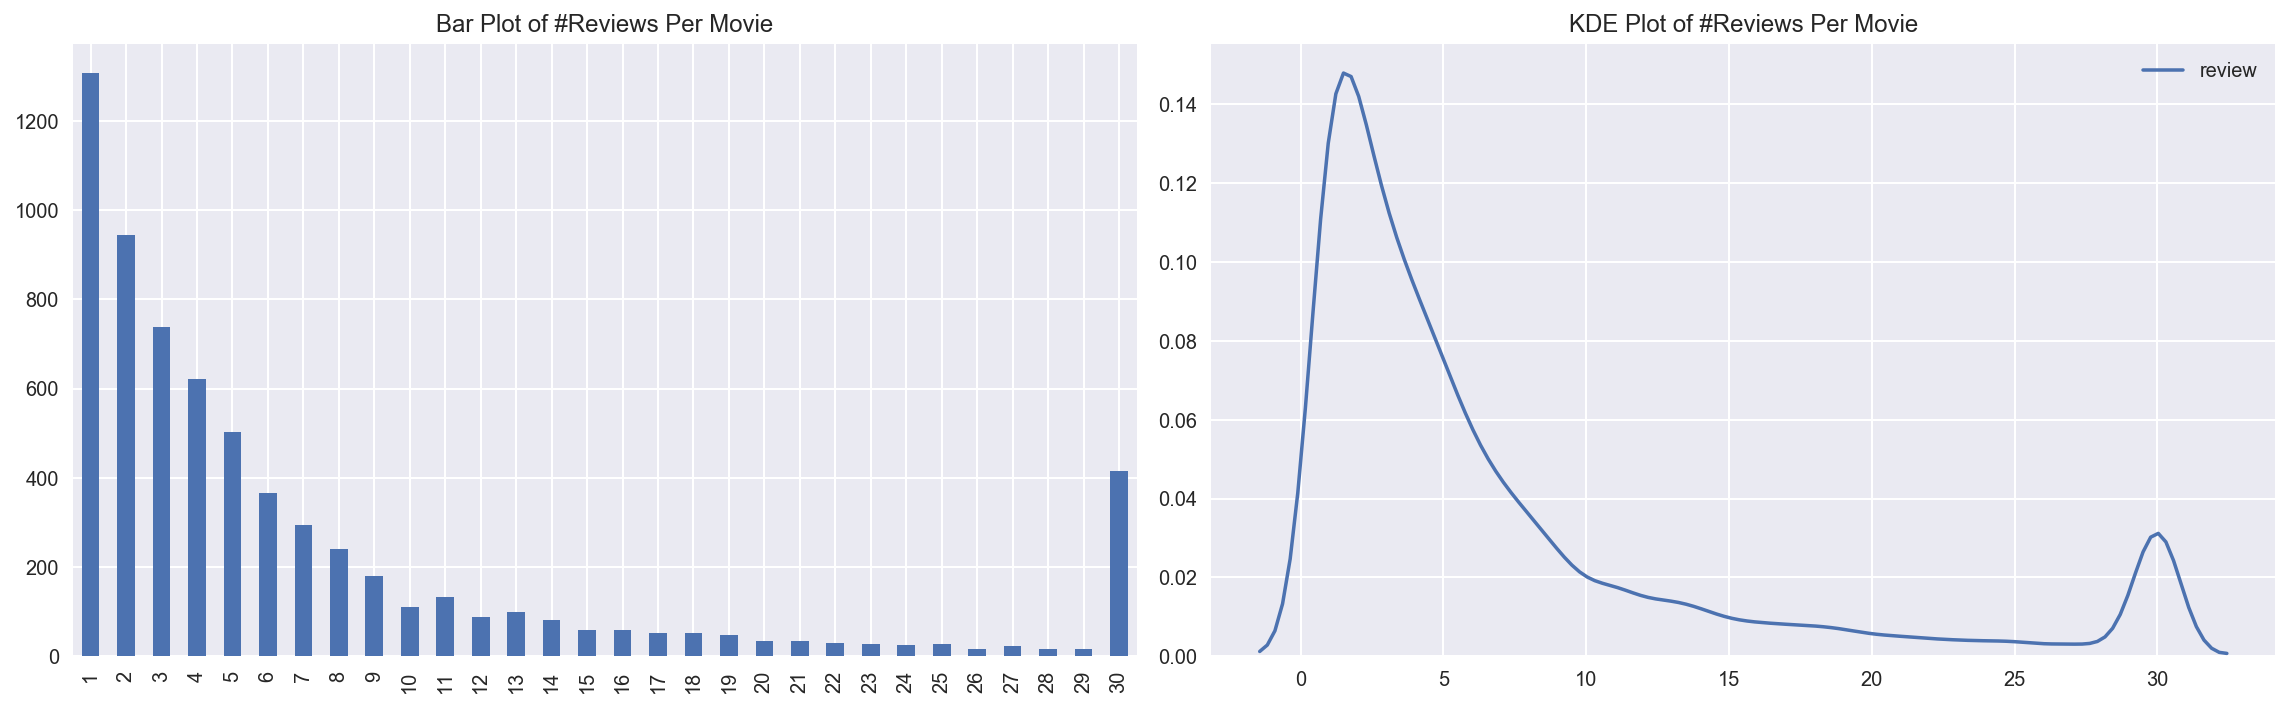

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
# Display characteristic data
print('median:', dft.median())
display(dft.describe())

median: 4.0


count    6648.000000
mean        7.119585
std         7.987691
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        30.000000
Name: review, dtype: float64

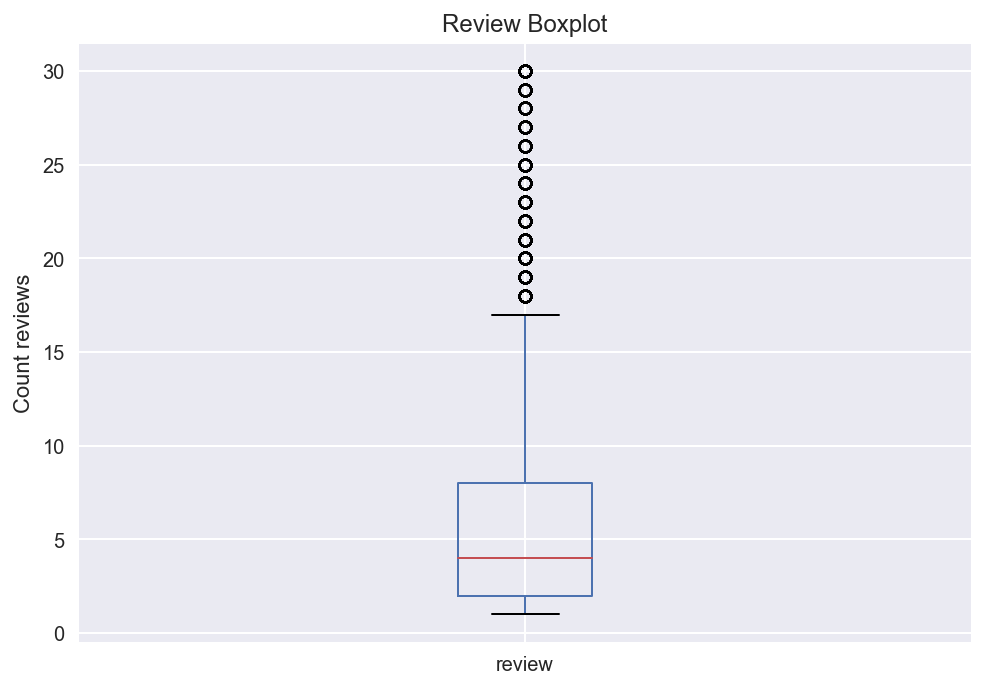

In [12]:
# Check for outliers / Data allocation
dft.plot(kind='box', 
         title='Review Boxplot',
         ylabel='Count reviews');

> **Observations:**
> - The data is shifted to the right 
> - In average movies have 7 ratings but 50% of the movies have 4 or less reviews
> - There is a peak at 30 reviews, which could be faulty data or have other origins like 30 different sources etc.

## 2.3. Rating distribution and comparison test/train set

> In this chapter the distribution of ratings (1-10) within the train and test set has been investigated in case that there are some obvious distortions

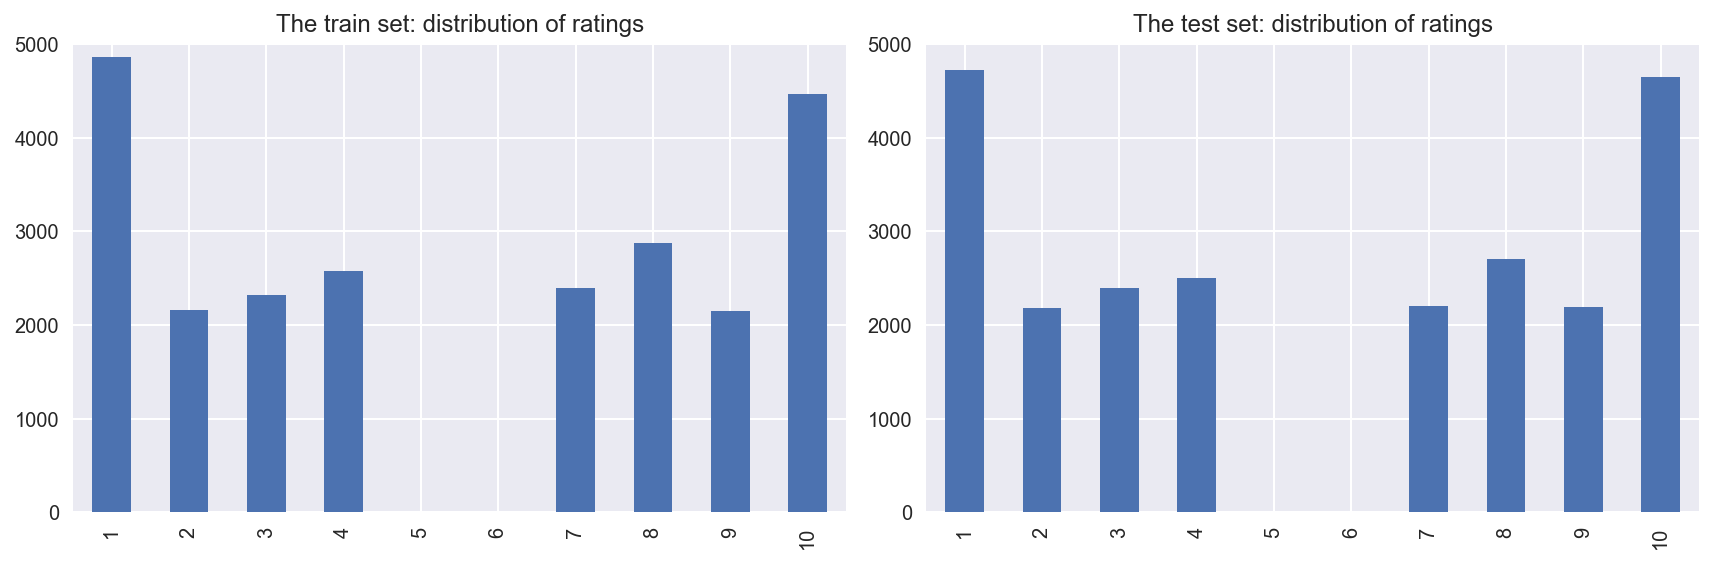

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

> **Observarion:**
> - Train and test set are more or less distributed equally
> - THere is a peak of verry good and verry bad movies whereas there are no/few ratings for 5 or 6

## 2.4. Positive and negative reviews

> In this step, the distribution of negative and positive reviews over the years has been determined

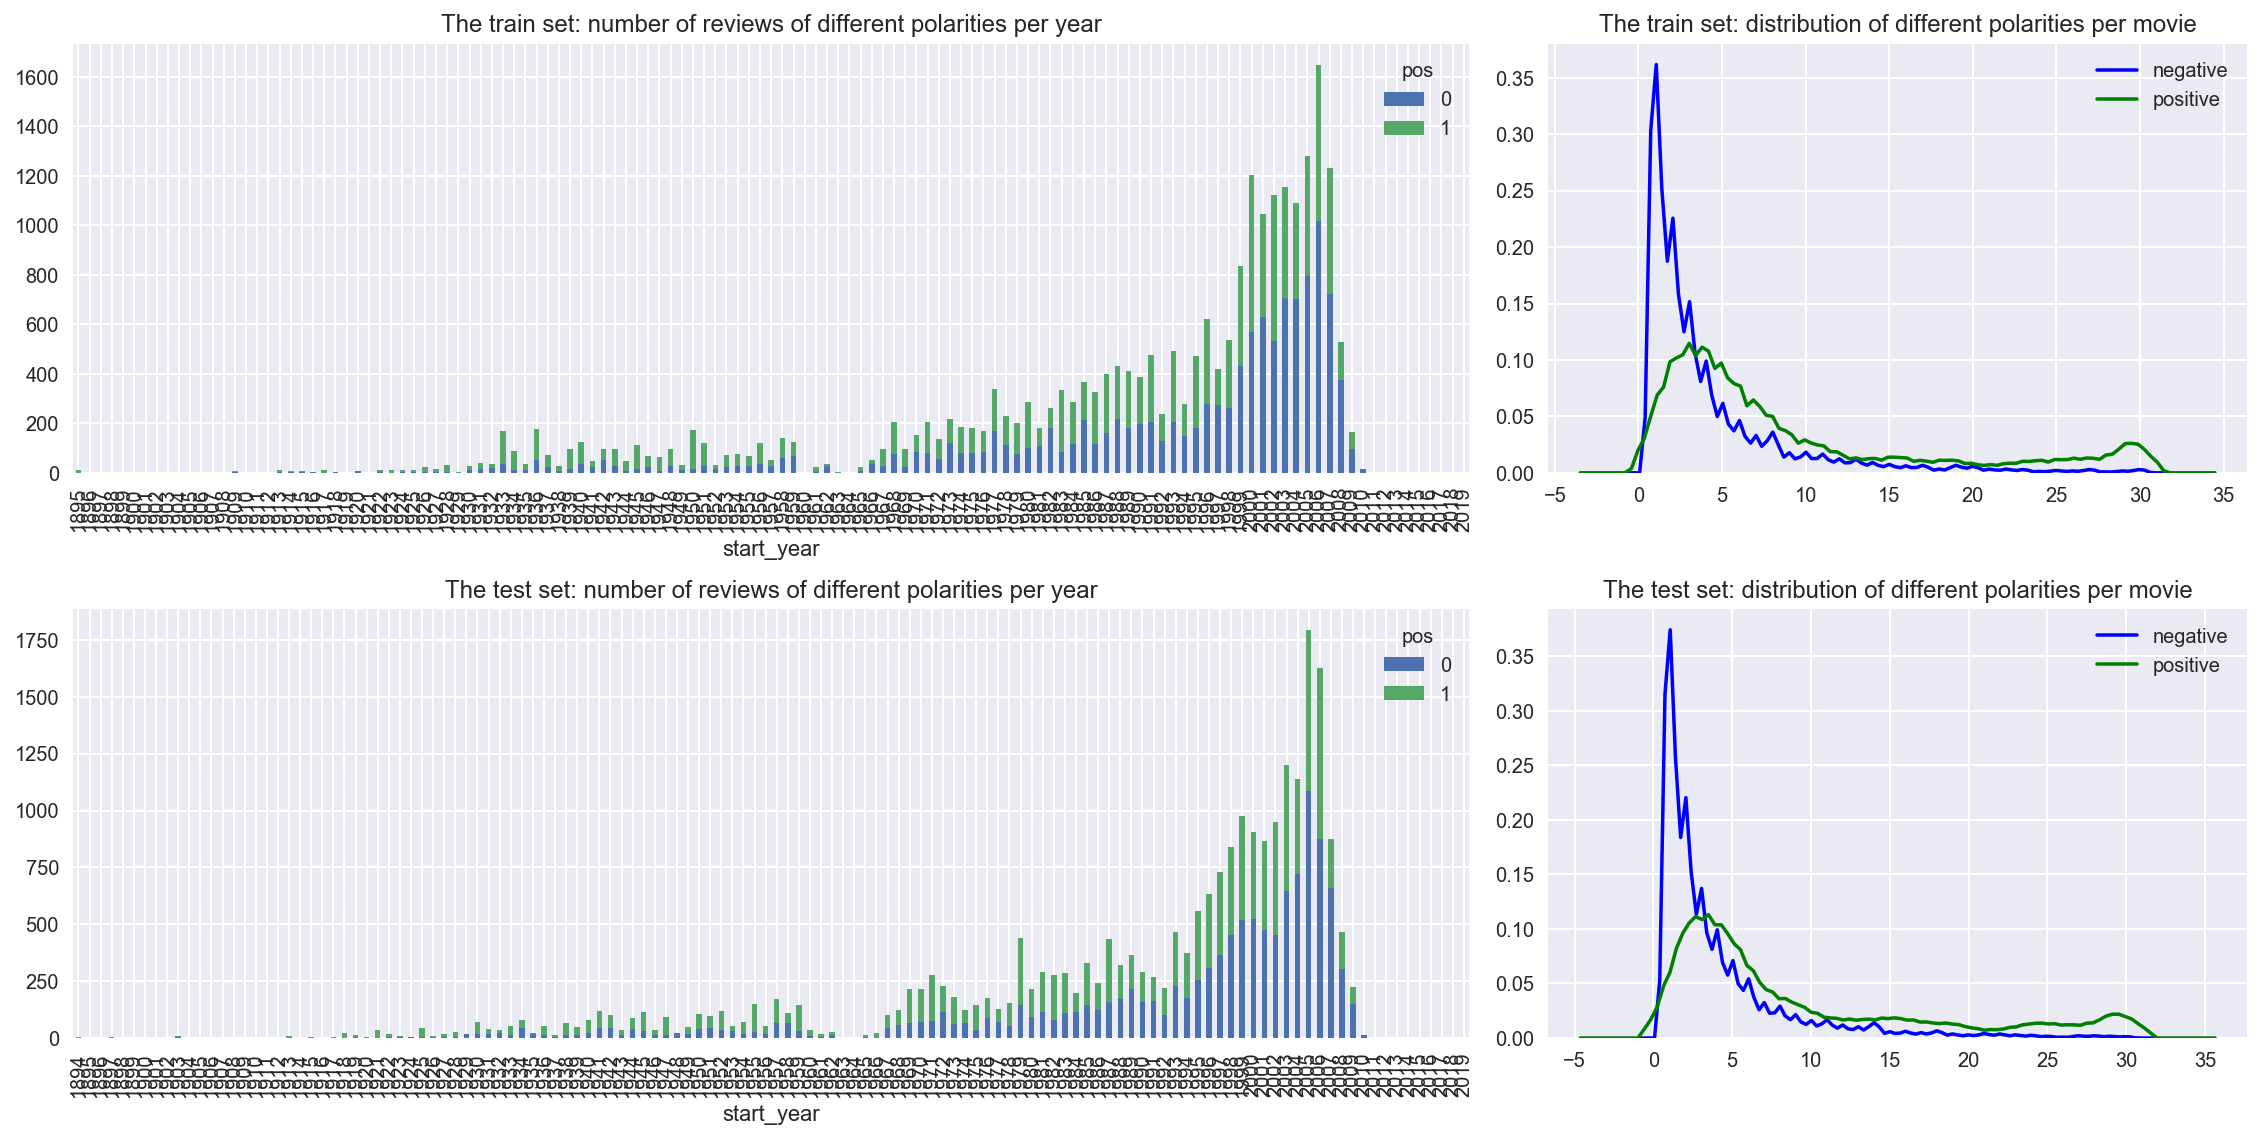

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

> **Observations:**
> - In general there are more positive reviews per year than negative ones
> - The distributions for the est and train set seem to be quite similar 

# 3. Model Building

## 3.1. Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
def evaluate_model(model, train_features, y_train, test_features, y_test):
    '''Evalueates the overhand model based on the trainings and test data
    It plots F1, ROC and PRC curves for the train and the test data as well as their maximas
    arguments:
        model: model to evaluate
        train_features: dataframe or arrayalike structure with the train feartures
        y_train: list(alike structure) of labels
        test_features: dataframe or arrayalike structure with test features, needs same shape than train_features
        y_test: list(alike structure) of labels
    returns
        None
        '''
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, y_train), ('test', test_features, y_test)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## 3.2 Preprocessing: Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    '''decontractes contracted words using regex
    arguments:
        phrase: string of text 
    returns:
        phrase: string of decontracted text'''
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def normalize(s):
    '''Converts the text into lower case and removes all
    non-Characters and multiple spaces
    arguments:
        s: string to nomalize
    returns:
        s: normalized string'''
    s = decontracted(s.lower())
    s = re.sub(r'[^a-zA-Z]', ' ', s)
    s = ' '.join(s.split())
    return s

In [17]:
# Check funcitonality of function and apply it
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)
print(f"Before:\n{df_reviews['review'][0]}")
print(f"After:\n{df_reviews['review_norm'][0]}")

Before:
The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!
After:
the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that is not what i got out of it i did not get anything in the first half there is a new character without introduction in every other scene the first half hour is completely 

## 3.3. Train / Test Split

> In this step, the data is splitted into train and test set using the 'ds_part' flag (Ratio 50:50)

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']

X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## 3.4. Model Training

### 3.4.1. Dummy Baseline model
> For later evaluation of model performance this random dummy model has been created

In [19]:
from sklearn.dummy import DummyClassifier

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.51   0.5
F1         0.51   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5


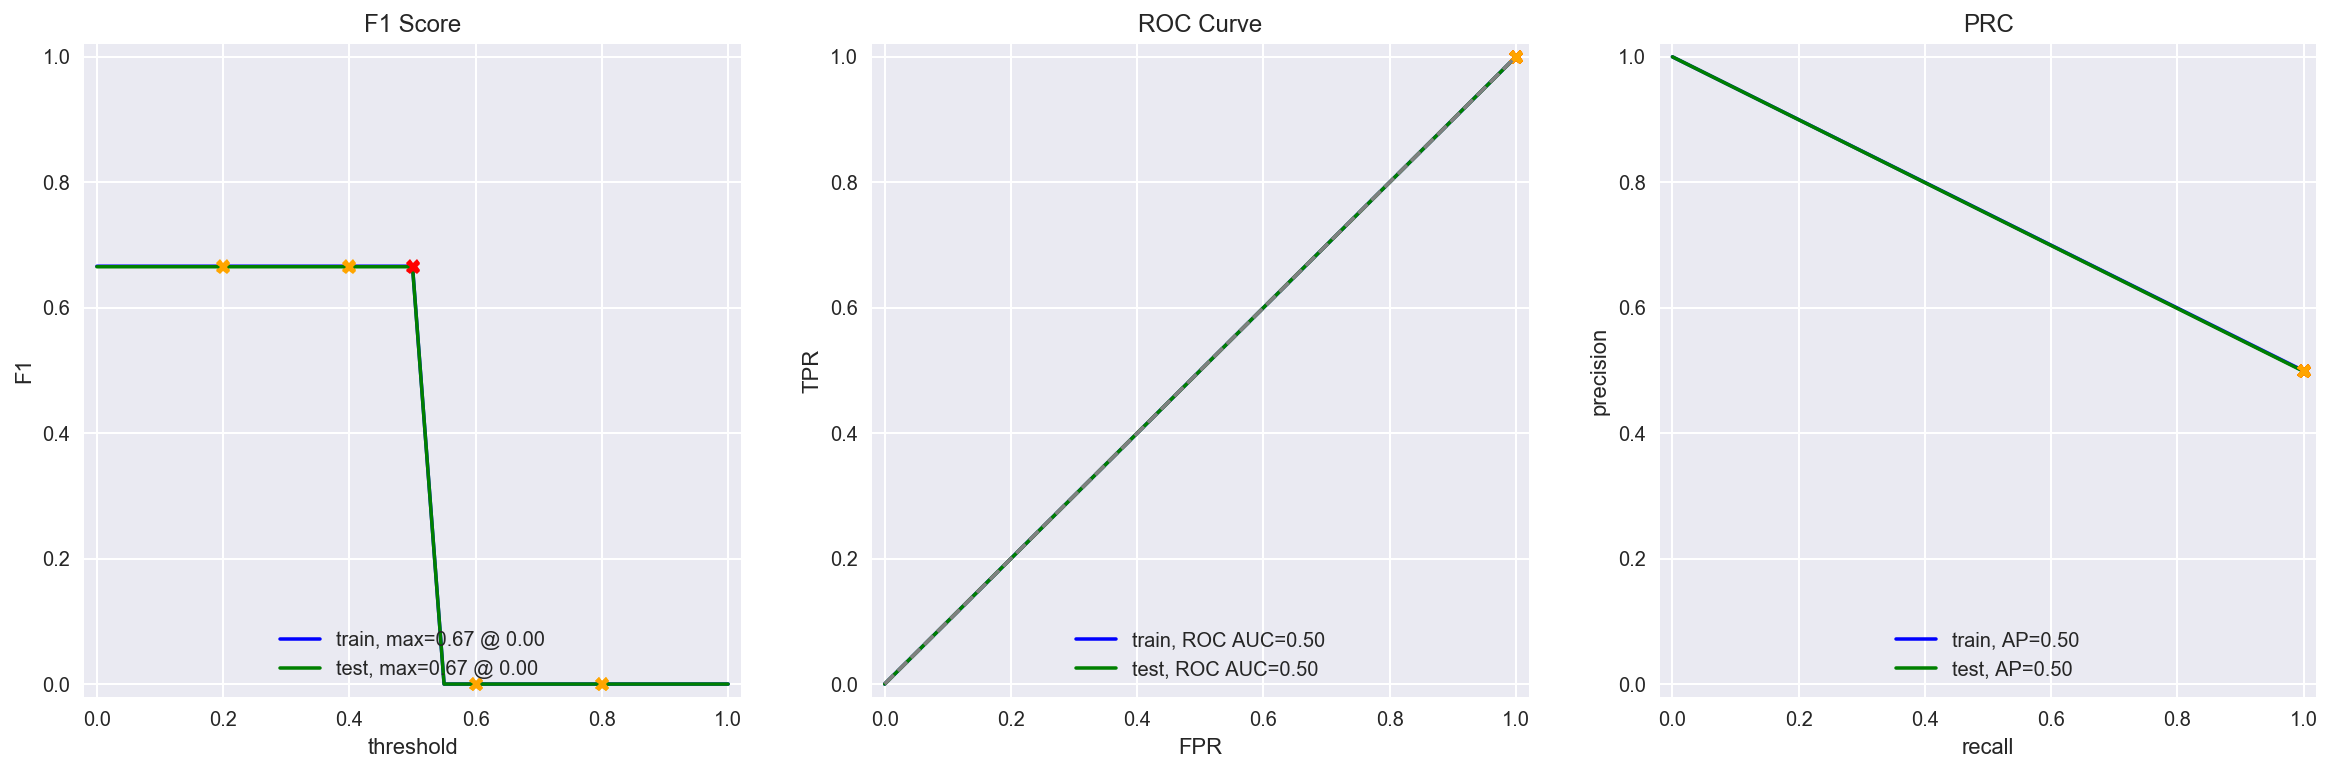

In [20]:
baseline = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
baseline.fit(df_reviews_train['review_norm'], y_train)
evaluate_model(baseline, df_reviews_train, y_train, df_reviews_test, y_test)

> **Observations:** 
> - As expected, the dummy modell has scores of 0.5 due to its uniform prediction strategy 

### 3.4.2. Model 1 - NLTK, TF-IDF and LR
> In this step the data has been preprocessed used NLTK and a logistic regression has been trained using TF-IDF values as features

#### 3.4.2.1. Basic model

In [21]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

In [22]:
# Instancing vectorizer with english stopwords
tfidf_vect_nltk = TfidfVectorizer(stop_words=set(nltk_stopwords.words('english')))

# transform all feature sets
X_train_nltk = tfidf_vect_nltk.fit_transform(X_train)
X_test_nltk = tfidf_vect_nltk.transform(X_test)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


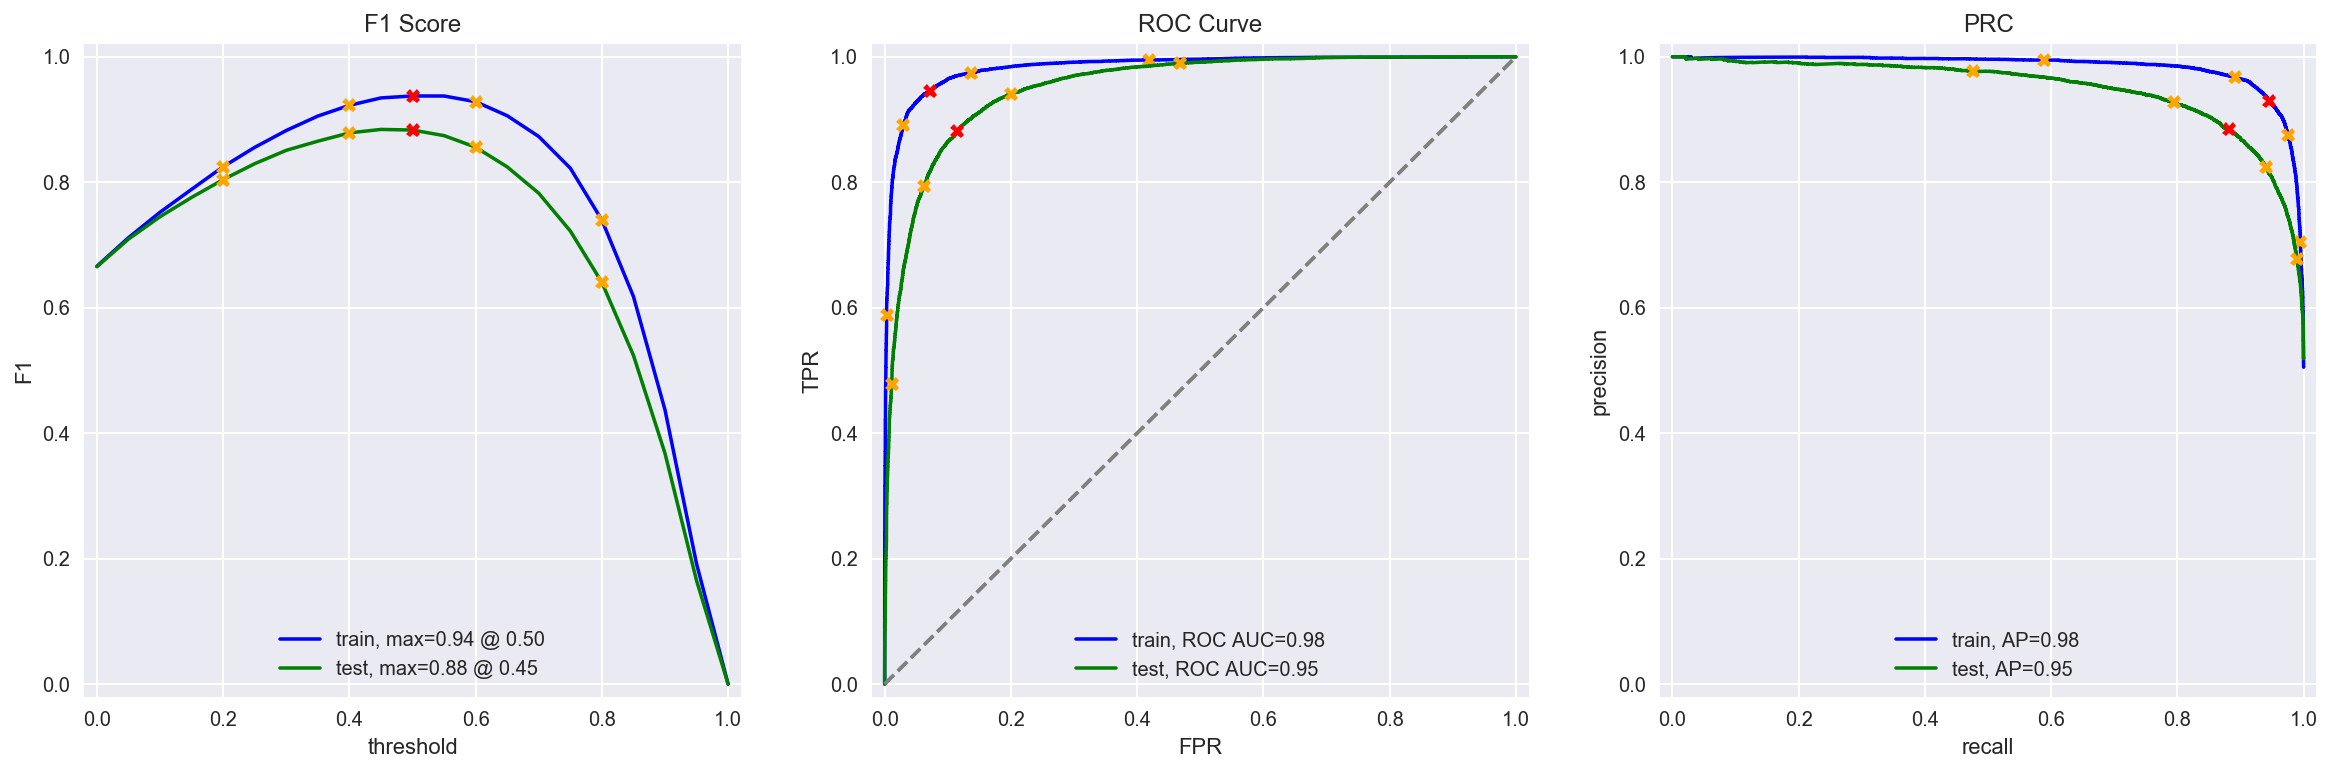

In [23]:
model_nltk = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model_nltk.fit(X_train_nltk, y_train)
evaluate_model(model_nltk, X_train_nltk, y_train, X_test_nltk, y_test)

> **Observations:** 
> - The model already fulfills the threshold of 85% accuracy ion the test data
> - The model shows tendencies of overfitting due to train accs of 94% and test accs of 88%

#### 3.4.2.2. Grid search
> To further improve the results, a grid search has been carried out

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.96  0.88
F1         0.96  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


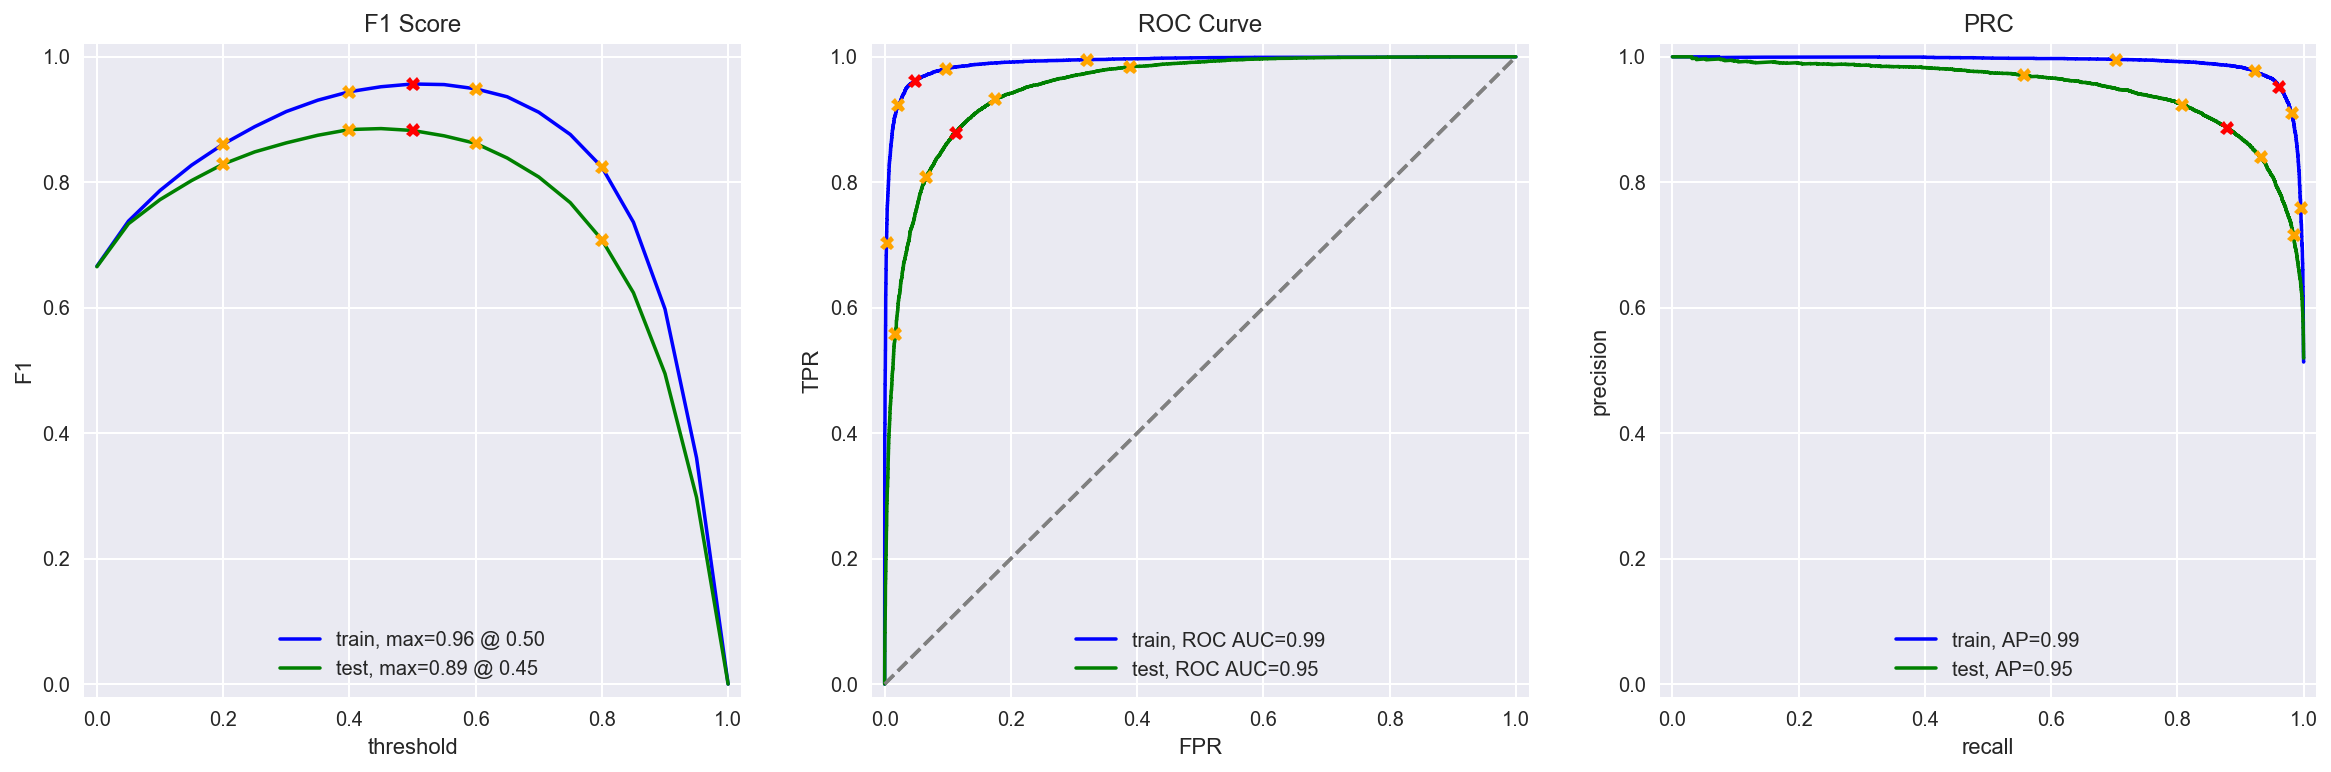

In [25]:
parameter_nltk = {
    'max_iter': [100,200,300],
    'solver': ['newton-cg', 'liblinear'],
    'C': [1, 1.5, 2]
}
logreg_nltk = LogisticRegression(random_state=RANDOM_STATE)
cs_nltk = GridSearchCV(logreg_nltk,
                      param_grid=parameter_nltk,
                      scoring='roc_auc',
                      n_jobs=-1,
                      verbose=2,
                      cv=5)
cs_nltk.fit(X_train_nltk, y_train)
evaluate_model(cs_nltk.best_estimator_, X_train_nltk, y_train, X_test_nltk, y_test)

> **Observations:** 
> - The test accuracy stays the same but the train evaluation matrices improve drastically, which means that the modell still has a tendency of overfitting

### 3.4.3. Model 2 - spaCy, TF-IDF and LR

#### 3.4.3.1. Basic model

In [26]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    '''lemmatizes text and removes stop words
    arguments:
        text: string to lemmatize
    returns:
        joined lematized tokens as string'''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop)]
    return ' '.join(tokens)

In [28]:
def preprocess_spacy(series):
    '''preprocesses series using spaCy
    arguments:
        series: pd.Series with the texts
    returns:
        pd.Series with the preprocessed texts
    '''
    data_spacy_l = []
    for n in tqdm((series.index)):
        data_spacy_l.append(text_preprocessing_3(series[n]))
    return pd.Series(data=data_spacy_l, index=series.index)

In [29]:
# Preprocess the data
X_train_spacy = preprocess_spacy(X_train)
X_test_spacy = preprocess_spacy(X_test)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [30]:
# Get Tfidf Vectors
tfidf_vect_spacy = TfidfVectorizer(stop_words=stopwords_spacy)

# transform all feature sets
X_train_spacy = tfidf_vect_spacy.fit_transform(X_train_spacy)
X_test_spacy = tfidf_vect_spacy.transform(X_test_spacy)

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


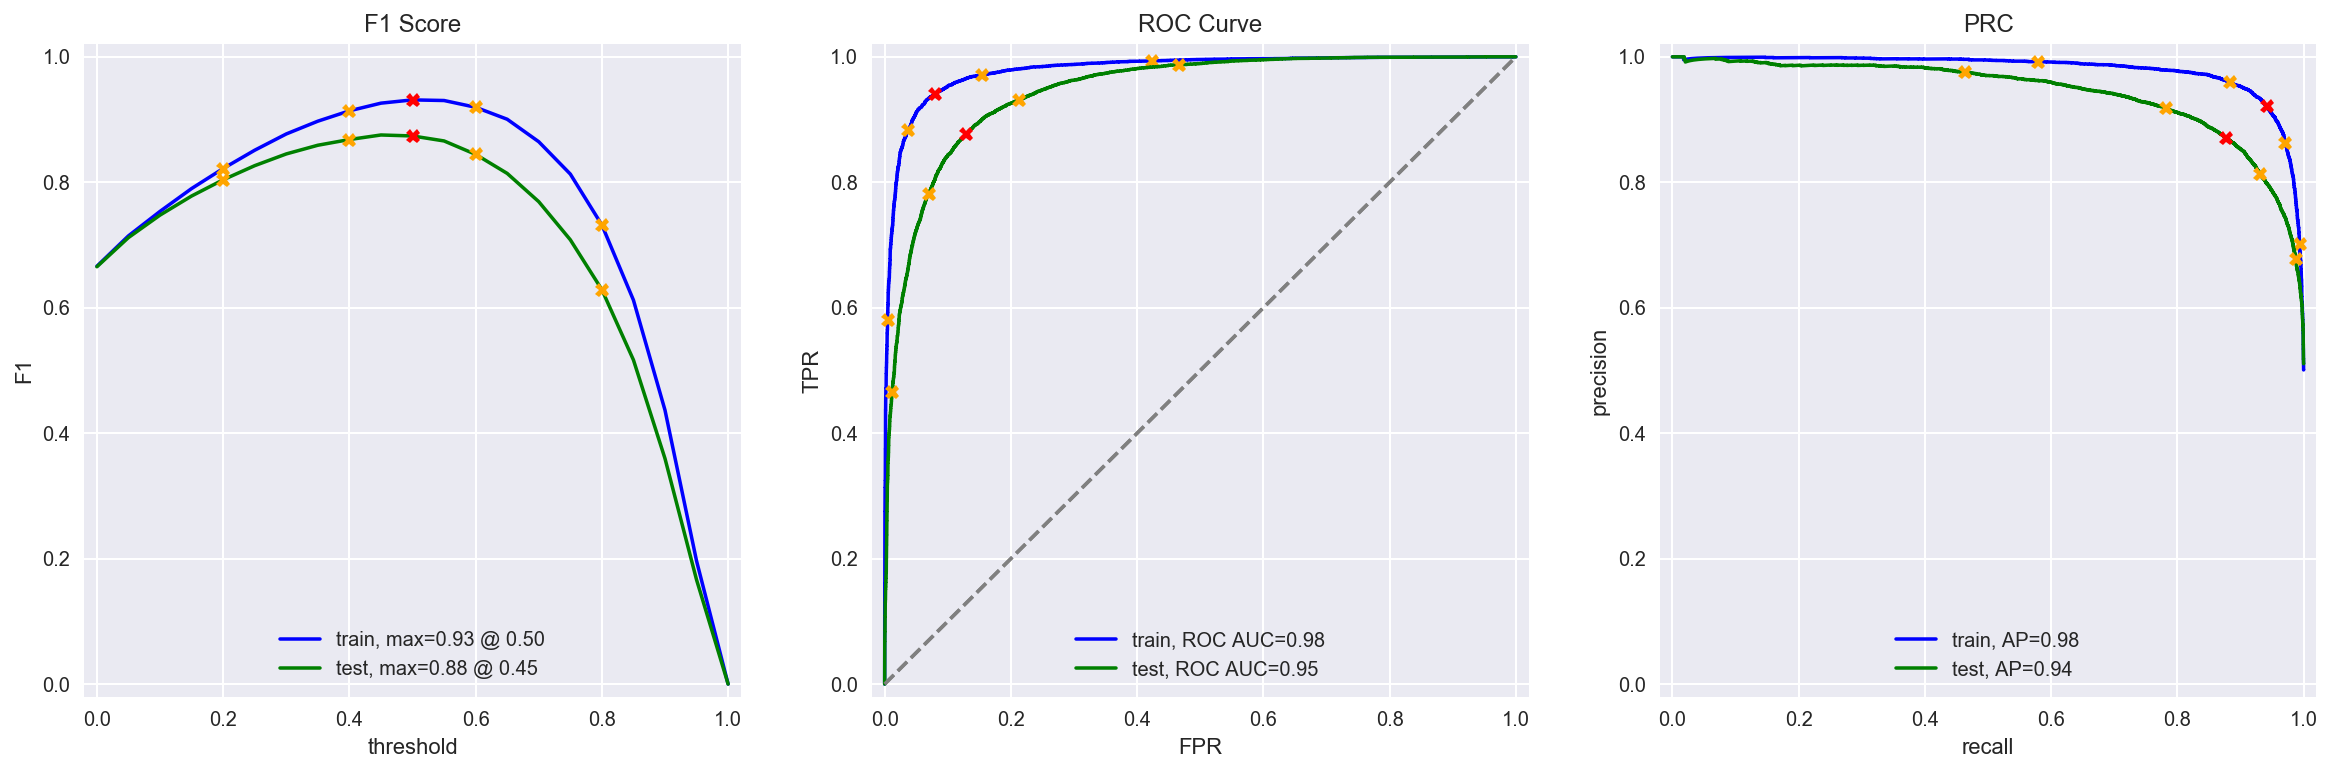

In [31]:
# tain logistig regression
model_spacy = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model_spacy.fit(X_train_spacy, y_train)
evaluate_model(model_spacy, X_train_spacy, y_train, X_test_spacy, y_test)

> **Observations:** 
> - Model quality is nearly as good as the one vectorized with NLTK

#### 3.4.3.2. Grid search

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   42.9s finished
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.87
F1         0.94  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


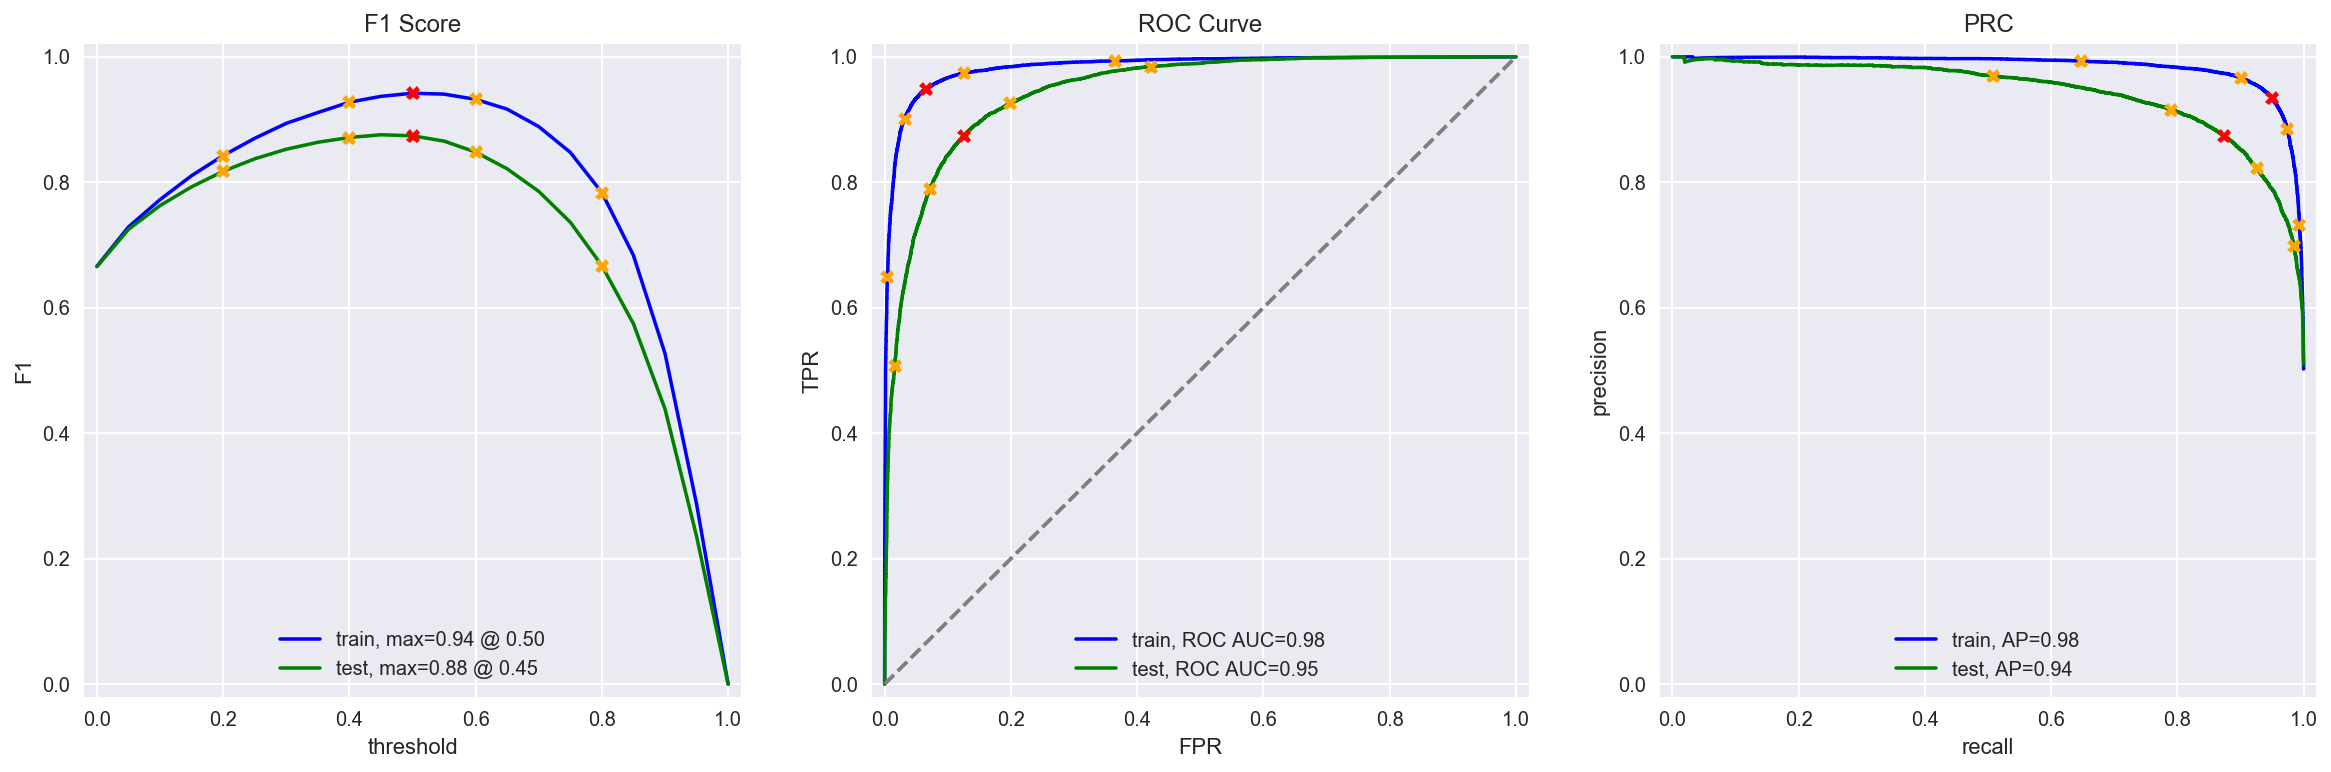

In [32]:
parameter_spacy = {
    'max_iter': [100,200,300],
    'solver': ['newton-cg', 'liblinear'],
    'C': [1, 1.5, 2]
}
logreg_spacy = LogisticRegression(random_state=RANDOM_STATE)
cs_spacy = GridSearchCV(logreg_spacy,
                      param_grid=parameter_spacy,
                      scoring='roc_auc',
                      n_jobs=-1,
                      verbose=2,
                      cv=5)
cs_spacy.fit(X_train_spacy, y_train)
evaluate_model(cs_spacy.best_estimator_, X_train_spacy, y_train, X_test_spacy, y_test)

> **Observations:** 
> - The Quality improves slightly but is still lower than the quality of the first model
> - The model does not tempt to overfitt as much as the last model 2

### 3.4.4. Model 4 - spaCy, TF-IDF and LGBMClassifier
> In this step a LGBM Classifier has been built on data preprocessesd using spacy to lemmatize

In [33]:
from lightgbm import LGBMClassifier

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


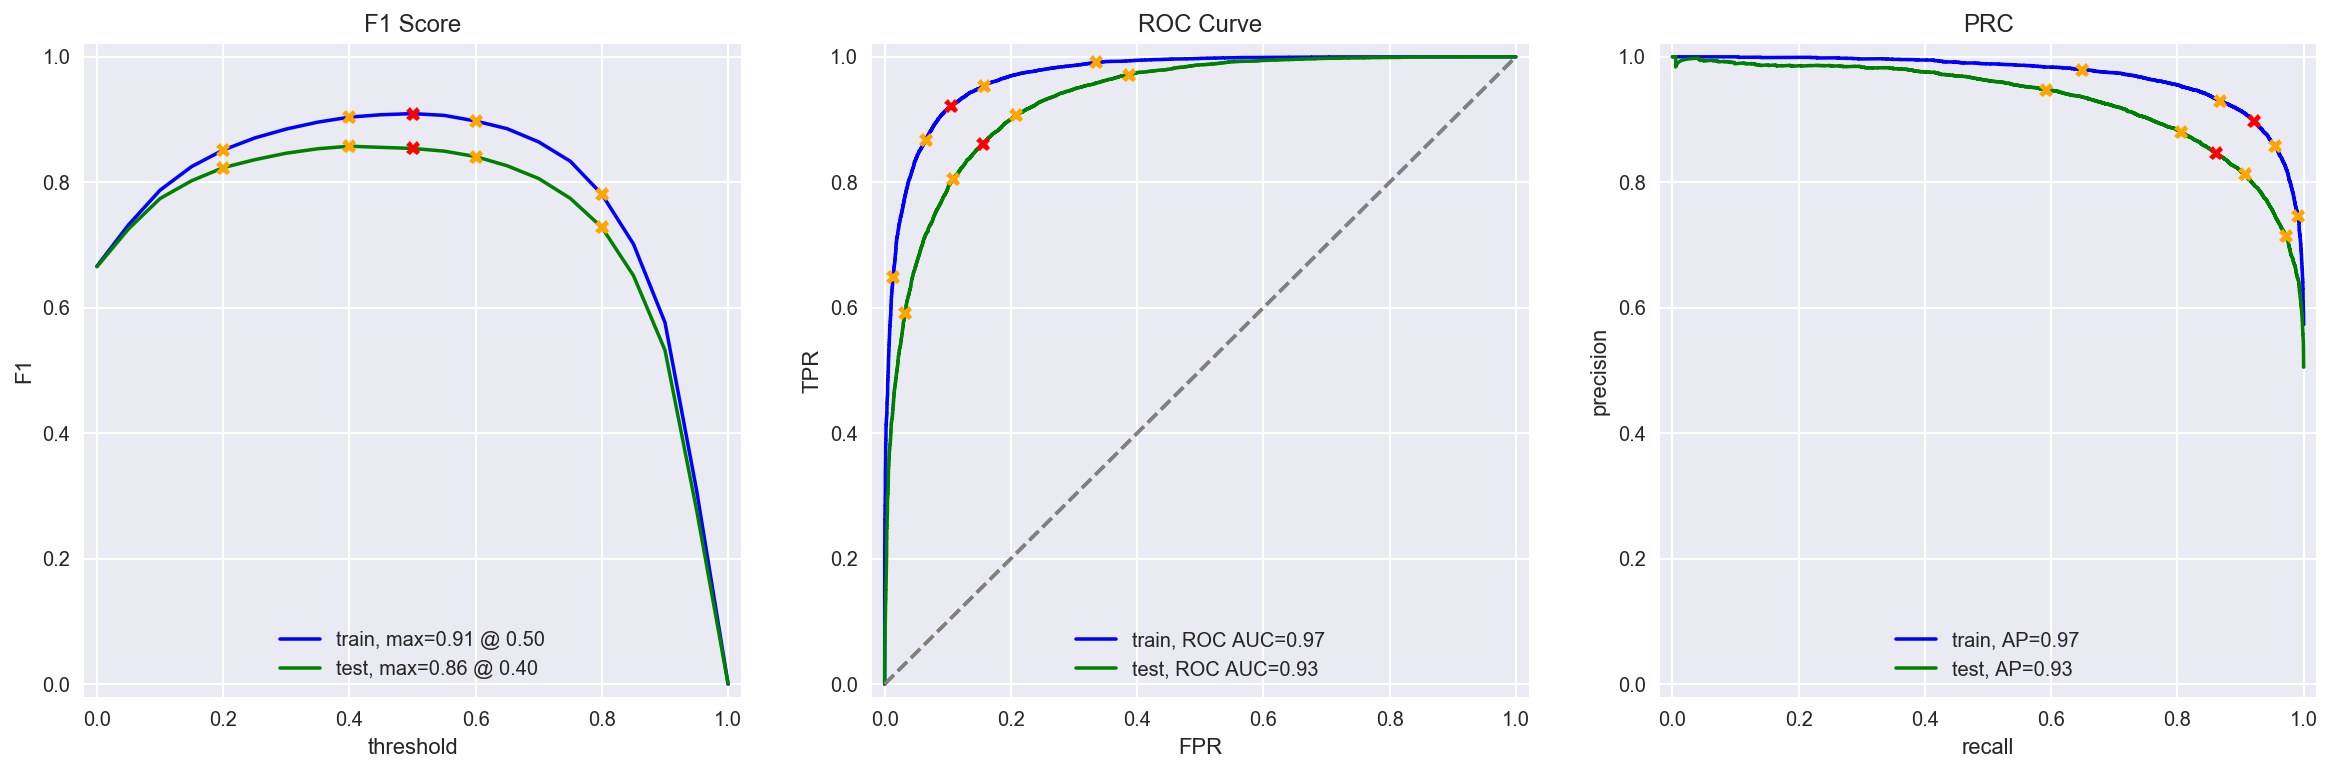

In [34]:
model_LGBM = LGBMClassifier(random_state=RANDOM_STATE)
model_LGBM.fit(X_train_spacy, y_train)
evaluate_model(model_LGBM, X_train_spacy, y_train, X_test_spacy, y_test)

> **Observations:** 
> - The model is significant worse than the previous ones, therefore is no hyperparameter tuning

<div class="alert alert-block alert-success">
<b>Success:</b> This part was done prefectly!
</div>

### 3.4.5. BERT, LR

> In this chapter the Texts have been vectorized using BERT and a Logistic regression

#### 3.4.5.1. Bert embeddings
> In this chapter the texts have been tokenized and imbedded using bert for later model training

In [35]:
import torch
import transformers

In [36]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ''' This function embeddes the given text with a specifyable lenght offering multiple device settings
    arguments:
        texts: pd.Series with texts
        max_length=512: int defining lenght of text which will be considered in embeddings
        batch_size=100: int wich defines batch sizes
        force_device=None: string of device or None
        disable_progress_bar=False: disabling the progress bar
        
    returns
        embeddings: Bert embeddings of the text
    '''
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')
    
    # Series with the ids per text
    ids_list = texts.apply(lambda x: tokenizer.encode(x.lower(),
                                                      add_special_tokens=True, 
                                                      truncation=True, 
                                                      max_length=max_length))
    # Padding zeros to make all lists same length
    ids_list = ids_list.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    # Create attention mask -> ignore zeros later on 
    attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        # putting together vectors of ids (of tokens) to a tensor
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)
        
        # putting together vectors of attention masks to a tensor
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        # Because use of pretrained and no model training
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [37]:
# In order to retrain, set to 1, retrain =0 loads precomputed embeddings
retrain = 1
if retrain:
    # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
    train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'].iloc[:2000], batch_size=5, force_device='cpu')
    test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'].iloc[:1000], batch_size=5, force_device='cpu')
    # save the embeddings
    np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)
    print('embeddings generated and saved successfully')
else:
    with np.load('features_9.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
        print('Features loaded successfully')

Features loaded successfully


#### 3.4.5.2. Logistic Regression
> In this chapter a logistic regression has been trained using the first 2000 test datapoints and evaluated on the first 1000 train datapoints

[0.86364026 0.99520811 0.26247359 0.99963117 0.81587238 0.00597743
 0.0507868  0.01834204 0.0148973  0.52784322]
          train  test
Accuracy   0.96  0.83
F1         0.96  0.82
APS        0.99  0.92
ROC AUC    0.99  0.92


C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


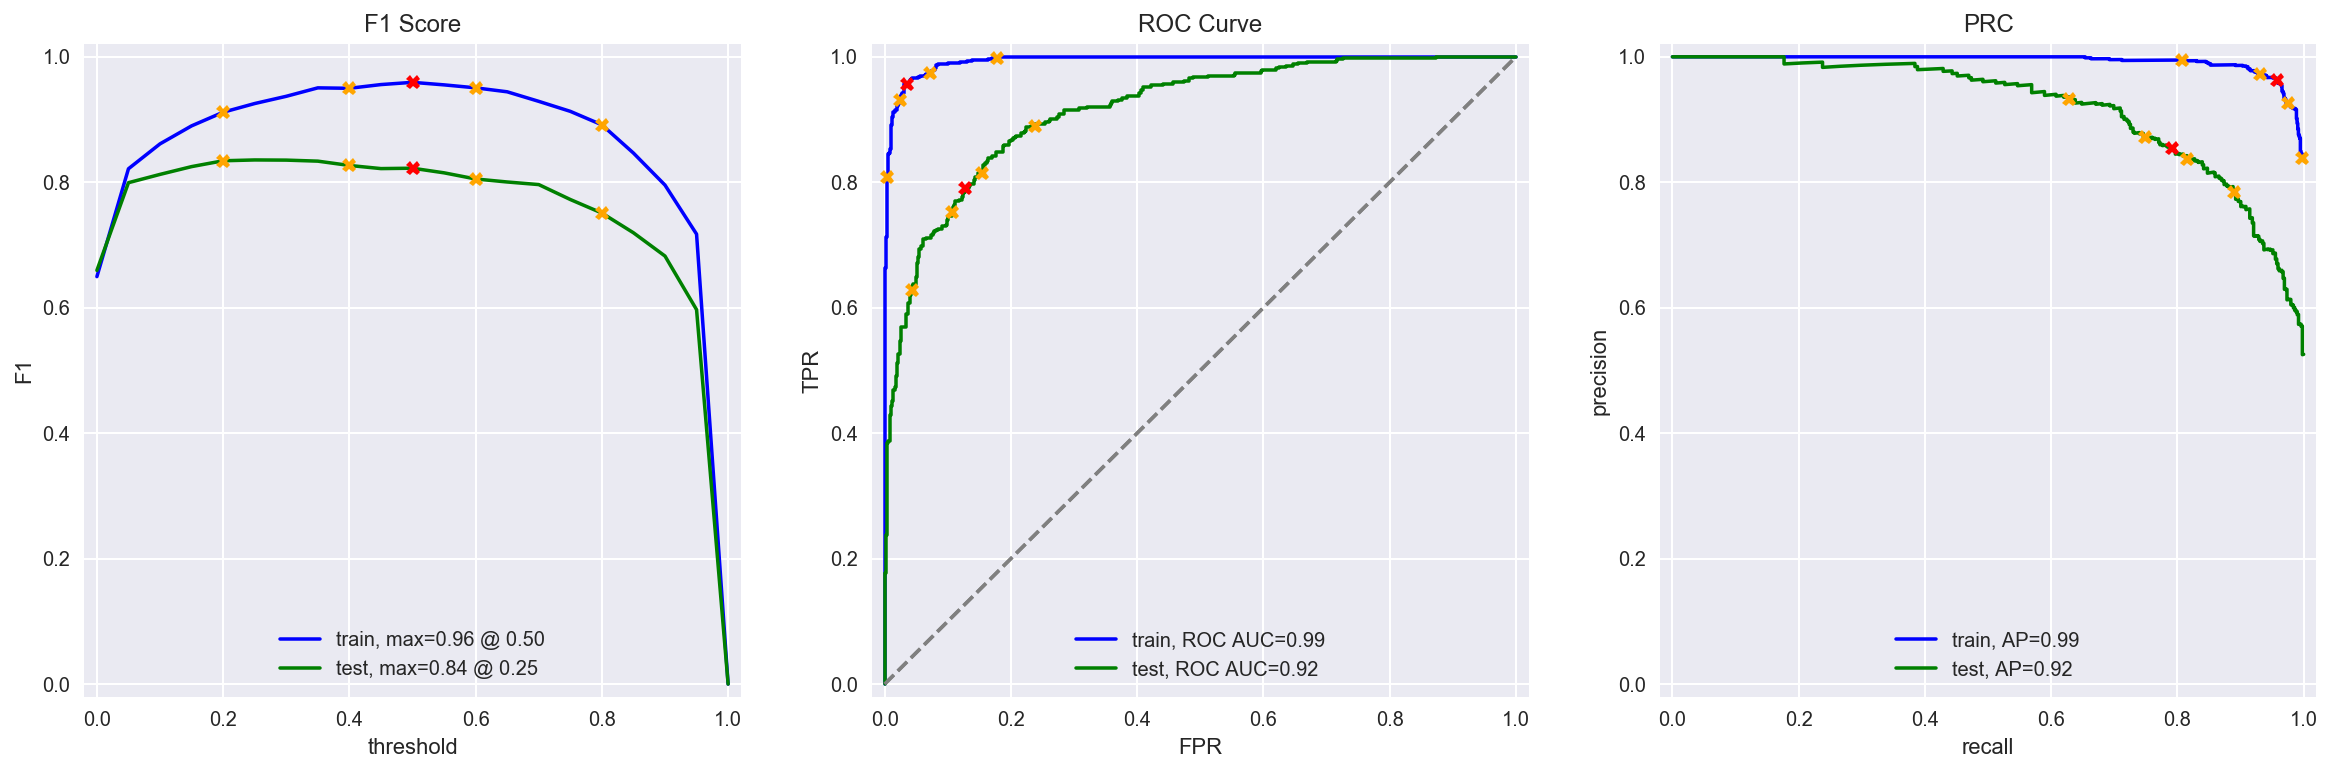

In [38]:
# Train and evaluate
logreg_bert = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
logreg_bert.fit(train_features_9, y_train[:2000])
probas = logreg_bert.predict_proba(test_features_9[:10])[:, 1]
print(probas)
evaluate_model(logreg_bert, train_features_9, y_train[:2000], test_features_9, y_test[:1000])

> **Observations:**
> - The quality of the model is lower than using the tfidf values
> - That quality discrepancy most likely is related to the different train and test dataset sizes (Factor 10 for train and factor 20 for test)
> - To further improve the model, the impact of the logreg threashold is investigated in the next step

In [39]:
from sklearn.metrics import confusion_matrix

# Investigating if threashold needs to be adjusted for better f1 score
scope = 1000
pred_proba_df = pd.DataFrame(logreg_bert.predict_proba(test_features_9[:scope]))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    f1_score = metrics.f1_score(y_test[:scope].to_numpy().reshape(y_test[:scope].to_numpy().size,1),
                                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1))
    print(f'F1 score is: {round(f1_score, 4)}')
    print('Confusion matrix:')
    print(confusion_matrix(y_test[:scope].to_numpy().reshape(y_test[:scope].to_numpy().size,1),
                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
F1 score is: 0.7993
Confusion matrix:
[[294 214]
 [ 22 470]]

******** For i = 0.1 ******
F1 score is: 0.8126
Confusion matrix:
[[338 170]
 [ 39 453]]

******** For i = 0.15 ******
F1 score is: 0.825
Confusion matrix:
[[369 139]
 [ 49 443]]

******** For i = 0.2 ******
F1 score is: 0.8343
Confusion matrix:
[[388 120]
 [ 54 438]]

******** For i = 0.25 ******
F1 score is: 0.8356
Confusion matrix:
[[398 110]
 [ 60 432]]

******** For i = 0.3 ******
F1 score is: 0.8353
Confusion matrix:
[[413  95]
 [ 71 421]]

******** For i = 0.35 ******
F1 score is: 0.8337
Confusion matrix:
[[425  83]
 [ 81 411]]

******** For i = 0.4 ******
F1 score is: 0.8268
Confusion matrix:
[[431  77]
 [ 91 401]]

******** For i = 0.45 ******
F1 score is: 0.8218
Confusion matrix:
[[438  70]
 [100 392]]

******** For i = 0.5 ******
F1 score is: 0.8224
Confusion matrix:
[[443  65]
 [103 389]]

******** For i = 0.55 ******
F1 score is: 0.8151
Confusion matrix:
[[449  59]
 [113 379]]

****

> **Observations:**
> -  The f1 score of the model could be improved slightly by setting the threashold to .25 
> - To finally evaluate this change, the test set need to be splitted in eval and test set to avoid overfitting
> - Due to the fact that even with the adjusted threashold, the model quality is still lower than the one for tfidf embeddings, those steps have not been carried out

# 4. My Reviews

## 4.1. Creation and normalization

In [40]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'This new movie was really amazing, even if i normally do not like this kind of movie',
    'It was okay but i would not reccomend it ',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, verry flat monologes and a lot of logic gaps. I will never watch it again',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: normalize(x))
my_reviews

,review,review_norm
0,"This new movie was really amazing, even if i n...",this new movie was really amazing even if i no...
1,It was okay but i would not reccomend it,it was okay but i would not reccomend it
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i did not expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, verry...",the movie had its upsides and downsides verry ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


## 4.2. NLTK tfidf and Logreg

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_nltk.predict_proba(tfidf_vect_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  this new movie was really amazing even if i normally do not like this kind of movie
0.23:  it was okay but i would not reccomend it
0.54:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i did not expect the reboot to be so good writers really cared about the source material
0.42:  the movie had its upsides and downsides verry flat monologes and a lot of logic gaps i will never wa
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## 4.4. Spacy tfidf and Logreg

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_spacy.predict_proba(tfidf_vect_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.83:  this new movie was really amazing even if i normally do not like this kind of movie
0.36:  it was okay but i would not reccomend it
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i did not expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides verry flat monologes and a lot of logic gaps i will never wa
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


> **Observations:**
> - It seems that the probabilities for spacy would converge more towards 1 or 0 than the nltk provessed tfidf texts
> - Both models are predicting all texts right

## 4.5. Spacy tfidf and LGBM

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_LGBM.predict_proba(tfidf_vect_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.84:  this new movie was really amazing even if i normally do not like this kind of movie
0.52:  it was okay but i would not reccomend it
0.59:  i was really fascinated with the movie
0.42:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.64:  i did not expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides verry flat monologes and a lot of logic gaps i will never wa
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


> **Observations:**
> - The LGM classifier has really centered probabilies for the different reviews and classifies multiple reviews wrong

## 4.6. Bert and LR

In [44]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=False, batch_size=5)

my_reviews_pred_prob = logreg_bert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using the cpu device.


  0%|          | 0/2 [00:00<?, ?it/s]

0.97:  this new movie was really amazing even if i normally do not like this kind of movie
0.41:  it was okay but i would not reccomend it
0.97:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.76:  i did not expect the reboot to be so good writers really cared about the source material
0.00:  the movie had its upsides and downsides verry flat monologes and a lot of logic gaps i will never wa
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


> **Observations:**
> - The bert embedded Texts have a convergence beetween nltk and spacy but it need to be considered that this model is only trained with 2000 datapoints whereas the other models are trained with 23000 datapoints

# 5. Conclusion

> Within this project multiple cathegorization models for movie revies has been developed in the following steps:
> - EDA
> - Preprocessing and normalization
> - Model building

> The three approaches used within this project were the use of tfidf on normalized texts, tfidf on normalized + lemmatized texts and bert encoded texts.  
> It turned out that the tfidf calculation using lemmatized texts with spacy is leading to better results but requires much more computation.  
> About the quality of the Bert encoded results no final conclusion can be made due to the different training/test data value. But it can be said that they are nearly as good as the ones of the tfidf values even if they only contain factor 10 less training samples.

> Logistic regression seems to fit best for this classification task out of the tested algorithms (LR, LGBM, Random Forests) with an f1 score of .88
